# Analyze Embedding Vectors

In [1]:
import os

import pandas as pd
import numpy as np

from scipy.spatial import distance

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap

/home/mhuebsch/.conda/envs/capstone/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embed_path = "../data/embeddings"

## Load Dataset  
Load the BBBC021 original dataset incl. the embedding vectors created with one of the following pre-trained models  
* Inception V3 base model
* Inception V3 fine-tuned on the last 2 convolutional mixture layers
* Inception V3 last 2 layers finetuning + data augmentation (flip vertical and horizontal, random roation 90 degrees)
* DinoV2 vision transformer ViT-S/14

In [3]:
df = pd.read_csv(os.path.join(embed_path, "embeddings_l2l_MoA_only_8bit_bc.csv"))
df = df.drop(columns=["Unnamed: 0"])  # need to be removed, artifact of merging (should be fixed there)

In [4]:
df.head()

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
0,2,113,Week2_180607_D10_s1_w13459A84F-B9BB-4FB2-B58E-...,Week2/Week2_24121,Week2_180607_D10_s1_w2D35FB8FC-0085-4F4D-B14A-...,Week2/Week2_24121,Week2_180607_D10_s1_w440EA0925-FF71-447F-B395-...,Week2/Week2_24121,Week2_24121,D10,...,0.598801,0.165157,0.349580,0.240558,0.232831,0.190724,0.216562,0.466217,0.217871,0.476633
1,2,114,Week2_180607_D10_s2_w111F1FA1E-8B45-451D-9C50-...,Week2/Week2_24121,Week2_180607_D10_s2_w277BE8611-E2E6-456E-838C-...,Week2/Week2_24121,Week2_180607_D10_s2_w433B4BF8D-9087-401F-89B1-...,Week2/Week2_24121,Week2_24121,D10,...,0.774047,0.220835,0.647705,0.225403,0.237141,0.195058,0.157998,0.440013,0.349144,0.429633
2,2,115,Week2_180607_D10_s3_w13C4CF98E-5824-43A6-A319-...,Week2/Week2_24121,Week2_180607_D10_s3_w2D8C8A48C-6EAF-463F-A673-...,Week2/Week2_24121,Week2_180607_D10_s3_w4E03CCDE6-86D5-4F10-9B54-...,Week2/Week2_24121,Week2_24121,D10,...,0.537046,0.446406,0.603448,0.473396,0.434939,0.248369,0.138446,0.370426,0.472364,0.404236
3,2,116,Week2_180607_D10_s4_w1E4144E18-06FF-4789-8F9F-...,Week2/Week2_24121,Week2_180607_D10_s4_w25BD84D0B-672D-4292-87B7-...,Week2/Week2_24121,Week2_180607_D10_s4_w4A0FA5EEA-D0F6-4857-9C81-...,Week2/Week2_24121,Week2_24121,D10,...,1.065903,0.259793,0.182259,0.379818,0.290877,0.238712,0.317723,0.432714,0.536339,0.550825
4,2,353,Week2_180607_D10_s1_w199106068-CEA7-4BAB-83EA-...,Week2/Week2_24141,Week2_180607_D10_s1_w20787BC73-DFAE-40D7-80BA-...,Week2/Week2_24141,Week2_180607_D10_s1_w4E09AB7C1-BAF1-4FFE-BFC7-...,Week2/Week2_24141,Week2_24141,D10,...,0.584237,0.267403,0.693121,0.609006,0.171457,0.222612,0.192032,0.727877,0.513483,0.376689


Get embedding vector columns.

In [5]:
vec_cols = [c for c in df.columns if c[0] == "V"]

---

## Embedding Vectors by Compound  
Cosine distance

In [13]:
compound_dist_histos = dict()
compound_vec_stats = list()
compound_vec_dists = list()
for compound in df["Image_Metadata_Compound"].unique():
    df_compound = df[df["Image_Metadata_Compound"] == compound]
    compound_moa = df_compound["Image_Metadata_MoA"].unique()[0]

    df_mean_vec = (
        df_compound.groupby(["Image_Metadata_Compound"])[vec_cols].mean().reset_index()
    )
    df_compound_data = df_compound[vec_cols].to_numpy()
    df_compound_mean = df_mean_vec[vec_cols].to_numpy()

    num_compounds = df_compound_data.shape[0]

    compound_dist = np.zeros((df_compound_data.shape[0]))
    for i in range(df_compound_data.shape[0]):
        compound_dist[i] = distance.cosine(df_compound_mean[0], df_compound_data[i, :])

    num_vectors_min_90 = np.extract(compound_dist < 0.1, compound_dist).shape[0]
    # print(f"{compound}: Number vectors > 0.9 similarity: {num_vectors_min_90}")
    # print(f"{compound}: Percentage vectors > 0.9 similarity: {(num_vectors_min_90 / num_compounds) * 100:.3f}")
    compound_vec_stats.append(
        (
            compound,
            num_compounds,
            num_vectors_min_90,
            (num_vectors_min_90 / num_compounds) * 100,
        )
    )

    compound_histo = np.histogram(compound_dist)
    compound_dist_histos[compound] = compound_histo
    compound_vec_dists.extend(list(zip([compound]*len(compound_dist), compound_dist, [compound_moa]*len(compound_dist))))

df_compound_vec_dists = pd.DataFrame().from_records(
    data=compound_vec_dists, 
    columns=["compound", "distance", "moa"]
)
df_compound_vec_dists = df_compound_vec_dists.sort_values(by=["moa", "compound"])

df_compound_vec_stats = pd.DataFrame.from_records(
    data=compound_vec_stats,
    columns=["compound", "no vectors", "no vectors > 0.9", "percentage vectors > 0.9"],
)
df_compound_vec_stats.shape

(39, 4)

In [14]:
df_compound_vec_stats.head()

,compound,no vectors,no vectors > 0.9,percentage vectors > 0.9
0,ALLN,96,94,97.916667
1,alsterpaullone,64,57,89.062500
2,anisomycin,96,16,16.666667
3,bryostatin,64,47,73.437500
4,camptothecin,96,79,82.291667


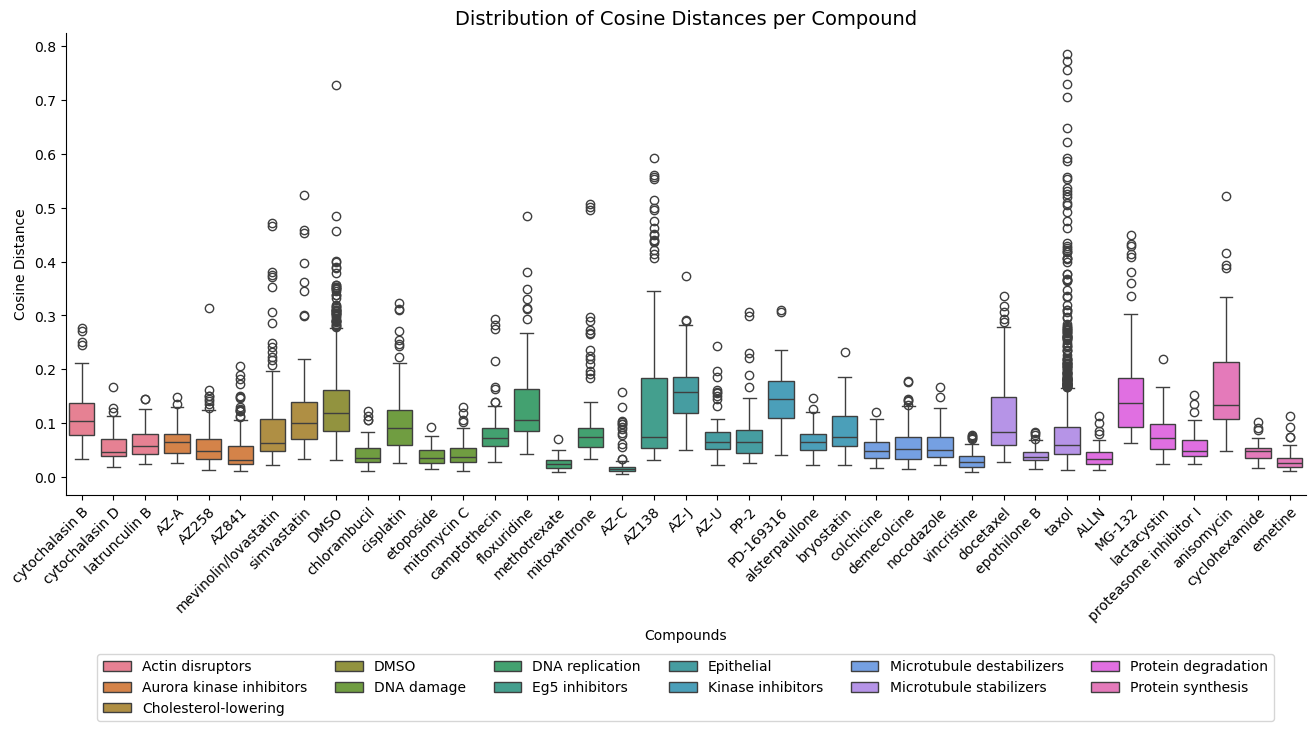

In [33]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(data=df_compound_vec_dists, x="compound", y="distance", hue="moa", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per Compound", fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.33), fancybox=True, shadow=False, ncol=6)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

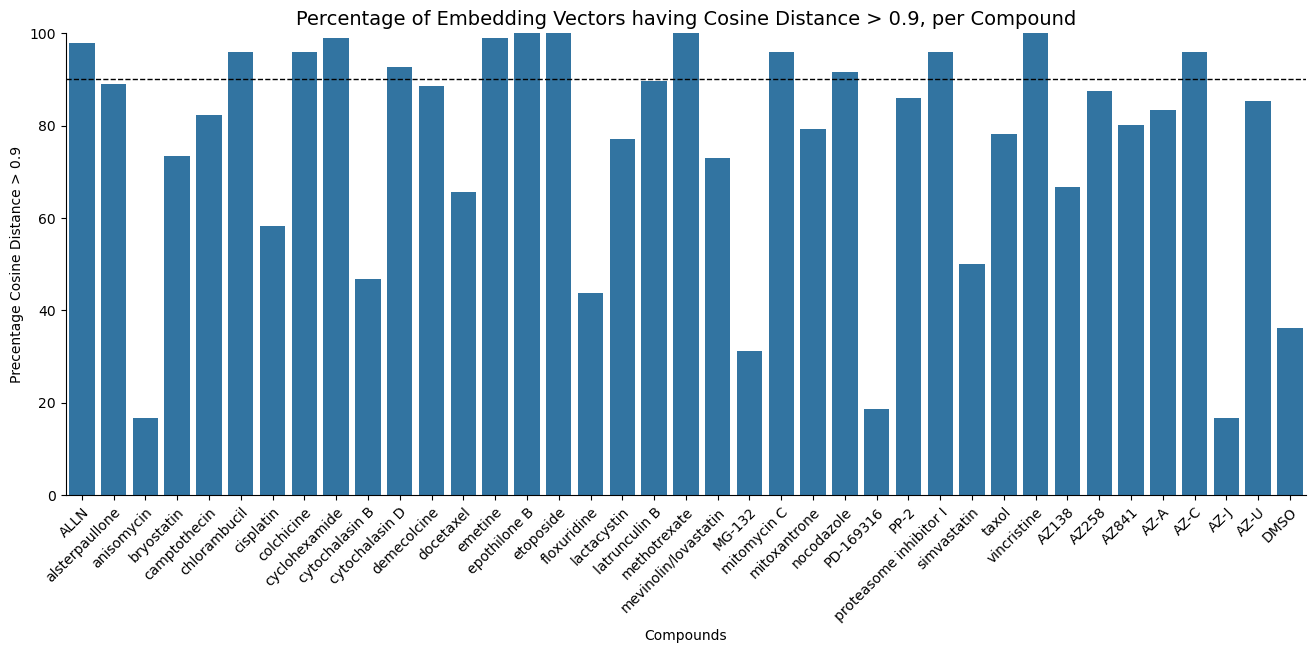

In [54]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(data=df_compound_vec_stats, x="compound", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per Compound", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

## Embedding Vectors by MoA  
Cosine distance

In [55]:
df["Image_Metadata_MoA"].unique()

array(['Protein degradation', 'Kinase inhibitors', 'Protein synthesis',
       'DNA replication', 'DNA damage', 'Microtubule destabilizers',
       'Actin disruptors', 'Microtubule stabilizers',
       'Cholesterol-lowering', 'Epithelial', 'Eg5 inhibitors',
       'Aurora kinase inhibitors', 'DMSO'], dtype=object)

In [56]:
df[df["Image_Metadata_MoA"] == "Protein degradation"].shape

(384, 2062)

In [57]:
moa_dist_histos = dict()
moa_vec_stats = list()
moa_vec_dists = list()
for moa in df["Image_Metadata_MoA"].unique():
    df_moa = df[df["Image_Metadata_MoA"] == moa]

    df_mean_vec = (
        df_moa.groupby(["Image_Metadata_MoA"])[vec_cols].mean().reset_index()
    )
    df_moa_data = df_moa[vec_cols].to_numpy()
    df_moa_mean = df_mean_vec[vec_cols].to_numpy()

    num_moas = df_moa_data.shape[0]

    moa_dist = np.zeros((df_moa_data.shape[0]))
    for i in range(df_moa_data.shape[0]):
        moa_dist[i] = distance.cosine(df_moa_mean[0], df_moa_data[i, :])

    num_vectors_min_90 = np.extract(moa_dist < 0.1, moa_dist).shape[0]
    # print(f"{moa}: Number vectors > 0.9 similarity: {num_vectors_min_90}")
    # print(f"{moa}: Percentage vectors > 0.9 similarity: {(num_vectors_min_90 / num_moa) * 100:.3f}")
    moa_vec_stats.append(
        (
            moa,
            num_moas,
            num_vectors_min_90,
            (num_vectors_min_90 / num_moas) * 100,
        )
    )

    moa_histo = np.histogram(moa_dist)
    moa_dist_histos[moa] = moa_histo
    moa_vec_dists.extend(list(zip([moa]*len(moa_dist), moa_dist)))

df_moa_vec_dists = pd.DataFrame().from_records(
    data=moa_vec_dists, 
    columns=["moa", "distance"]
)
df_moa_vec_stats = pd.DataFrame.from_records(
    data=moa_vec_stats,
    columns=["moa", "no vectors", "no vectors > 0.9", "percentage vectors > 0.9"],
)
df_moa_vec_stats.shape

(13, 4)

In [58]:
df_moa_vec_stats

,moa,no vectors,no vectors > 0.9,percentage vectors > 0.9
0,Protein degradation,384,284,73.958333
1,Kinase inhibitors,192,94,48.958333
2,Protein synthesis,288,213,73.958333
3,DNA replication,384,245,63.802083
4,DNA damage,384,316,82.291667
5,Microtubule destabilizers,384,313,81.510417
6,Actin disruptors,288,154,53.472222
7,Microtubule stabilizers,1608,1251,77.798507
8,Cholesterol-lowering,192,103,53.645833
9,Epithelial,256,148,57.812500


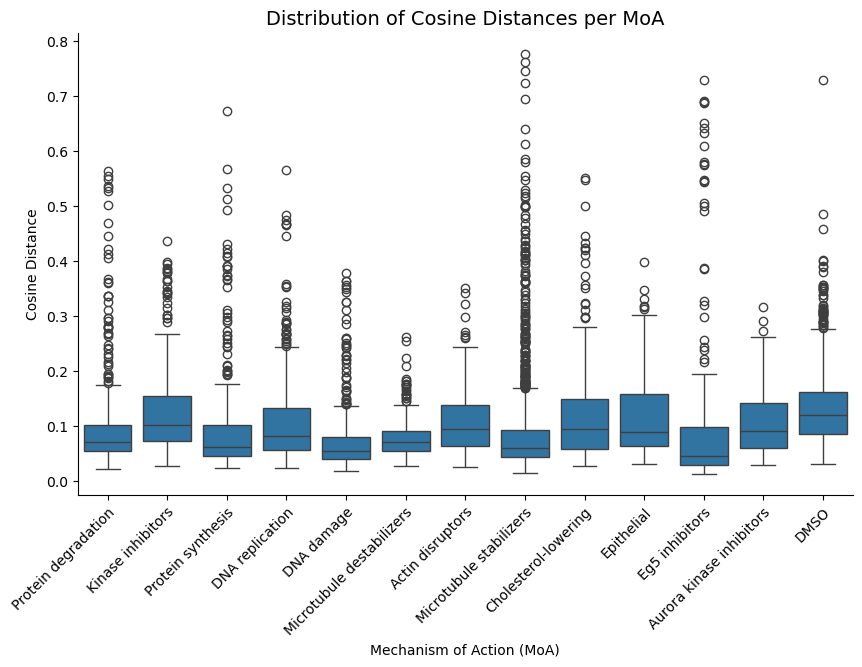

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df_moa_vec_dists, x="moa", y="distance", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per MoA", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

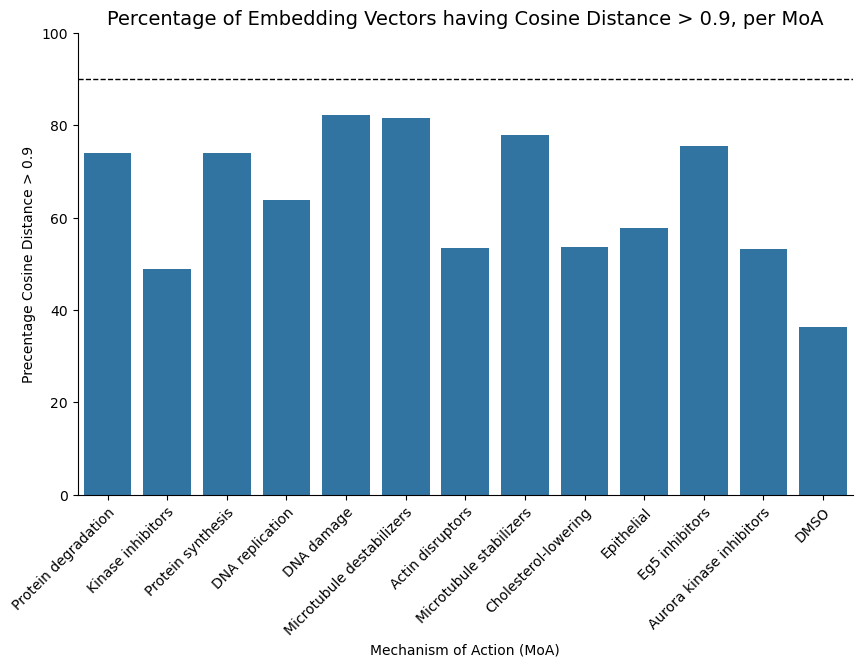

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_moa_vec_stats, x="moa", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per MoA", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

## Compounds Close to DMSO  
Cosine distance

In [61]:
df_dmso_mean = (
    df[df["Image_Metadata_Compound"] == "DMSO"]
    .groupby(["Image_Metadata_Compound"])[vec_cols]
    .mean()
    .reset_index()
)
dmso_mean_vec = df_dmso_mean[vec_cols].to_numpy()[0]

In [62]:
df_compounds = df[df["Image_Metadata_Compound"] != "DMSO"]
df_compounds.shape

(4840, 2062)

In [63]:
dmso_compound_dist = list()
for compound in df_compounds["Image_Metadata_Compound"].unique():
    df_compound = df[df["Image_Metadata_Compound"] == compound]
    df_mean_vec = (
        df_compound.groupby(["Image_Metadata_Compound"])[vec_cols].mean().reset_index()
    )
    mean_vec = df_compound[vec_cols].to_numpy()[0]

    dist_to_dmso = distance.cosine(dmso_mean_vec, mean_vec)
    dmso_compound_dist.append((compound, dist_to_dmso, 1 - dist_to_dmso))

df_dmso_compound_dist = pd.DataFrame().from_records(
    data=dmso_compound_dist,
    columns=["compound", "cosine distance", "cosine similarity"],
)
df_dmso_compound_dist.shape

(38, 3)

In [64]:
df_dmso_compound_dist

,compound,cosine distance,cosine similarity
0,ALLN,0.173833,0.826167
1,alsterpaullone,0.140241,0.859759
2,anisomycin,0.123847,0.876153
3,bryostatin,0.227864,0.772136
4,camptothecin,0.300770,0.699230
5,chlorambucil,0.158455,0.841545
6,cisplatin,0.167959,0.832041
7,colchicine,0.307081,0.692919
8,cyclohexamide,0.175812,0.824188
9,cytochalasin B,0.058347,0.941653


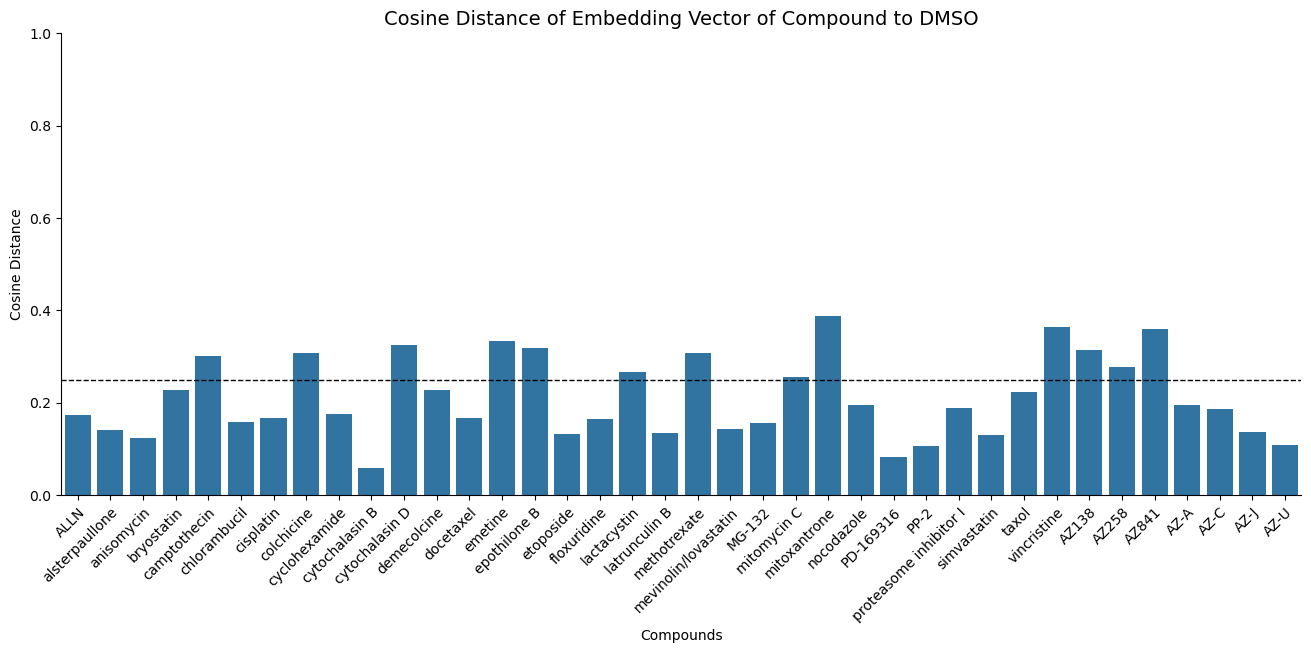

In [65]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(data=df_dmso_compound_dist, x="compound", y="cosine distance", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Cosine Distance")
ax.set_title("Cosine Distance of Embedding Vector of Compound to DMSO", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 1)
plt.axhline(y=0.25, linewidth=1, linestyle="--", color="black")

plt.show()

## Treatment Vectors  
Per plate/well

In [66]:
metadata_cols = df.columns[:14]
metadata_cols

Index(['TableNumber', 'ImageNumber', 'Image_FileName_DAPI',
       'Image_PathName_DAPI', 'Image_FileName_Tubulin',
       'Image_PathName_Tubulin', 'Image_FileName_Actin',
       'Image_PathName_Actin', 'Image_Metadata_Plate_DAPI',
       'Image_Metadata_Well_DAPI', 'Replicate', 'Image_Metadata_Compound',
       'Image_Metadata_Concentration', 'Image_Metadata_MoA'],
      dtype='object')

In [67]:
df_treatment_vecs = (
    df.groupby(
        [
            "Image_Metadata_Plate_DAPI",
            "Image_Metadata_Well_DAPI",
            "Replicate",
            "Image_Metadata_Compound",
            "Image_Metadata_Concentration",
            "Image_Metadata_MoA",
        ]
    )[vec_cols]
    .mean()
    .reset_index()
)

In [68]:
df_treatment_vecs.shape

(1540, 2054)

In [69]:
df_treatment_vecs.head()

,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,Image_Metadata_MoA,V0,V1,V2,V3,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
0,Week10_40111,B02,1,DMSO,0.0,DMSO,0.329152,0.182670,0.653653,0.301282,...,0.493480,0.691962,0.673170,0.294648,0.758638,0.708489,0.149057,0.448668,0.244261,0.574436
1,Week10_40111,B11,1,taxol,0.3,Microtubule stabilizers,0.141502,0.795691,0.089647,0.390108,...,0.267071,0.156893,0.162518,0.906009,0.123000,0.218299,0.433497,0.831592,0.545760,0.068338
2,Week10_40111,C02,1,DMSO,0.0,DMSO,0.356045,0.227189,0.725408,0.142055,...,0.845039,0.580592,0.572725,0.262225,0.915239,0.783929,0.033380,0.609723,0.110013,0.521695
3,Week10_40111,C03,1,AZ138,30.0,Eg5 inhibitors,0.015694,0.047984,0.065215,0.048347,...,0.015423,0.652436,0.237545,-0.059812,0.092689,0.141601,1.061424,0.107461,0.063097,0.262670
4,Week10_40111,C04,1,AZ138,10.0,Eg5 inhibitors,0.065142,0.156299,0.104808,0.174084,...,0.061115,0.310600,0.202997,-0.028744,0.149890,0.180511,0.390786,0.224069,0.144730,0.274153


## Dimensionality Reduction - Clustering

In [88]:
moas = df_treatment_vecs["Image_Metadata_MoA"].unique()
treatment_vectors = df_treatment_vecs[vec_cols]
treatment_vectors.shape

(1540, 2048)

### t-SNE Clustering

In [104]:
tsne = TSNE(perplexity=42, n_components=2, metric="cosine")
tsne_treatment_vectors = tsne.fit_transform(treatment_vectors)
print(f"t-SNE embeddings shape: {tsne_treatment_vectors.shape}")

t-SNE embeddings shape: (1540, 2)


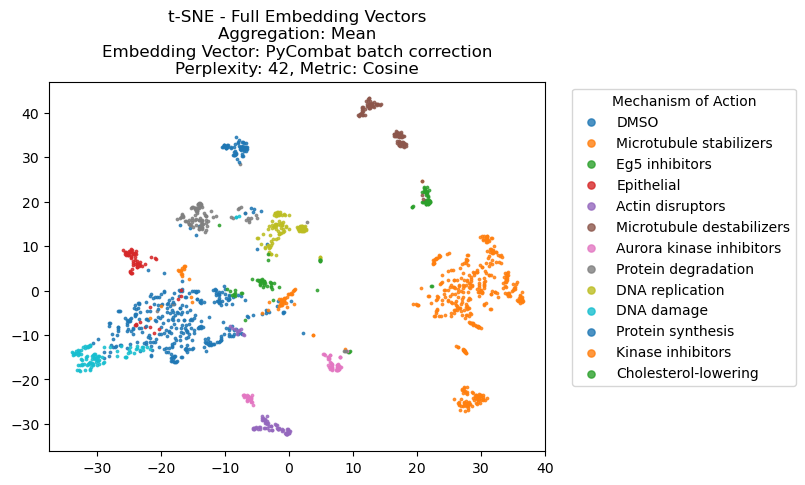

In [105]:


fig, ax = plt.subplots()

for moa in moas:
    idx = df_treatment_vecs[df_treatment_vecs["Image_Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(tsne_treatment_vectors[idx, 0], tsne_treatment_vectors[idx, 1], s=3, alpha=0.8, label=moa)
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("t-SNE - Full Embedding Vectors\nAggregation: Mean\nEmbedding Vector: PyCombat batch correction\nPerplexity: 42, Metric: Cosine")
# plt.savefig(os.path.join(image_dir, "t-sne_mean.png"), bbox_inches="tight")

plt.show()

### UMAP Clustering

In [106]:
umap_mean = umap.UMAP(min_dist=0.8, n_neighbors=50, metric="cosine")
umap_treatment_vectors = umap_mean.fit_transform(treatment_vectors)
print(f"UMAP embeddings shape: {umap_treatment_vectors.shape}")

UMAP embeddings shape: (1540, 2)


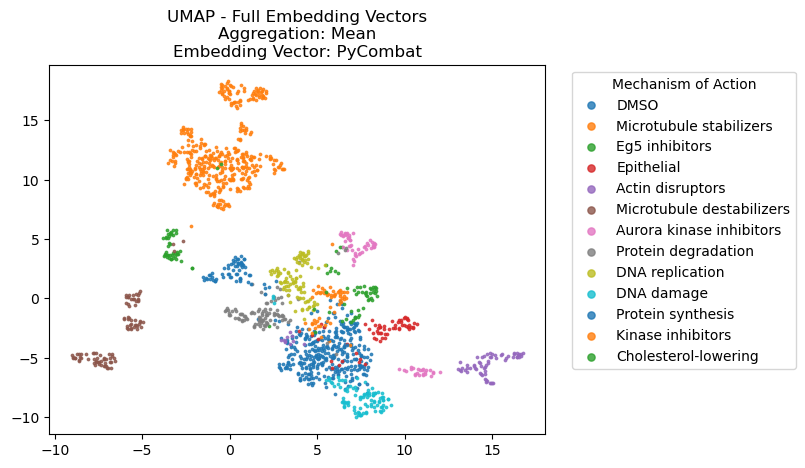

In [107]:
fig, ax = plt.subplots()

for moa in moas:
    idx = df_treatment_vecs[df_treatment_vecs["Image_Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(umap_treatment_vectors[idx, 0], umap_treatment_vectors[idx, 1], s=3, alpha=0.8, label=moa)
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("UMAP - Full Embedding Vectors\nAggregation: Mean\nEmbedding Vector: PyCombat")
# plt.savefig(os.path.join(image_dir, "umap_mean.png"), bbox_inches="tight")

plt.show()